In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import time
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import pad_sequences, set_random_seed
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, Dropout

#Гіперпараметри

In [3]:
max_features = 10000
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

#Завантаження даних

In [4]:
from keras.datasets import imdb

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)


17464789/17464789 [==============================] - 0s 0us/step


#Функція декодера

In [6]:
def decode_review(numberlist: list):
    word_to_id = imdb.get_word_index()
    word_to_id = {k: (v + 3) for k, v in word_to_id.items()}
    # word_to_id["<PAD>"] = 0
    # word_to_id["<START>"] = 1
    # word_to_id["<UNK>"] = 2
    # word_to_id["<UNUSED>"] = 3
    word_to_id = {v: k for k, v in word_to_id.items()}
    id_to_word = [
        word_to_id.get(word) for word in numberlist if word not in range(0, 3)
    ]
    return " ".join(id_to_word)

index = 1
print(f"Відгук: {input_train[index]}")
print(f"Декодований: {decode_review(input_train[index])}")
print(f"Мітка: {y_train[index]}")

Відгук: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
1641221/1641221 [==============================] - 0s 0us/step
Декодований: big hair big boobs bad music and a giant safety pin these are the words to best desc

#Передпроцесинг послідовних даних

In [7]:
x_train = pad_sequences(input_train, maxlen=maxlen)
x_test = pad_sequences(input_test, maxlen=maxlen)

#Побудова моделей RNN та LSTM

In [8]:
class BaseModel:
    def __init__(self, name, max_features, layer):
        self.name = name
        self.max_features = max_features
        self.build = self.build_model(layer)

    def build_model(self, layers: list):
        model = Sequential()
        model.add(Embedding(self.max_features, 64))
        for layer in layers:
            model.add(layer)
        model.add(Dropout(0.4))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
        return model


class SimpleRNNModel(BaseModel):
    def __init__(self, name="SRNN", max_features=max_features):
        super().__init__(name, max_features, [SimpleRNN(units=64)])


class BidirectionalRNNModel(BaseModel):
    def __init__(self, name="Bidirectional_SRNN", max_features=max_features):
        super().__init__(name, max_features, [Bidirectional(SimpleRNN(units=64))])


class LSTMModel(BaseModel):
    def __init__(self, name="LSTM", max_features=max_features):
        super().__init__(name, max_features, [LSTM(units=64)])


class BidirectionalLSTMModel(BaseModel):
    def __init__(self, name="Bidirectional_LSTM", max_features=max_features):
        super().__init__(
            name,
            max_features,
            [
                Bidirectional(LSTM(units=64)),
            ],
        )

#Створення моделей

In [9]:
models = []

for model_class in [
    SimpleRNNModel,
    BidirectionalRNNModel,
    LSTMModel,
    BidirectionalLSTMModel,
]:
    model_instance = model_class()
    models.append(model_instance)

#Навчання моделей

In [10]:
epochs = 5
batch_size = 2**6

models_info = {}
set_random_seed(42)

for model in models:
    print(f"\nStart learning model: {model.name}\n")
    model.build.summary()

    start_time = time.time()
    history = model.build.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
        verbose=1,
    )
    end_time = time.time()

    # Додаємо історію, та час навчання до словника
    models_info.setdefault(model.name, {})["history"] = history
    models_info[model.name]["edu_time"] = round(end_time - start_time, 2)

    start_time = time.time()
    test_loss, test_acc = model.build.evaluate(x_test, y_test)
    end_time = time.time()

    # Визначаємо функцію втрат та точність на тестових даних
    print(f"Test Loss: {test_loss:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")
    models_info[model.name]["test_loss"] = round(test_loss, 2)
    models_info[model.name]["test_acc"] = round(test_acc, 2)
    models_info[model.name]["eval_time"] = round(end_time - start_time, 2)


Start learning model: SRNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 648321 (2.47 MB)
Trainable params: 648321 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
274/274 [==============================] - 58s 205ms/step - loss: 0.6412 - acc: 0.6166 - val_loss: 0.6351 - val_a

#Візуалізація
##Криві навчання

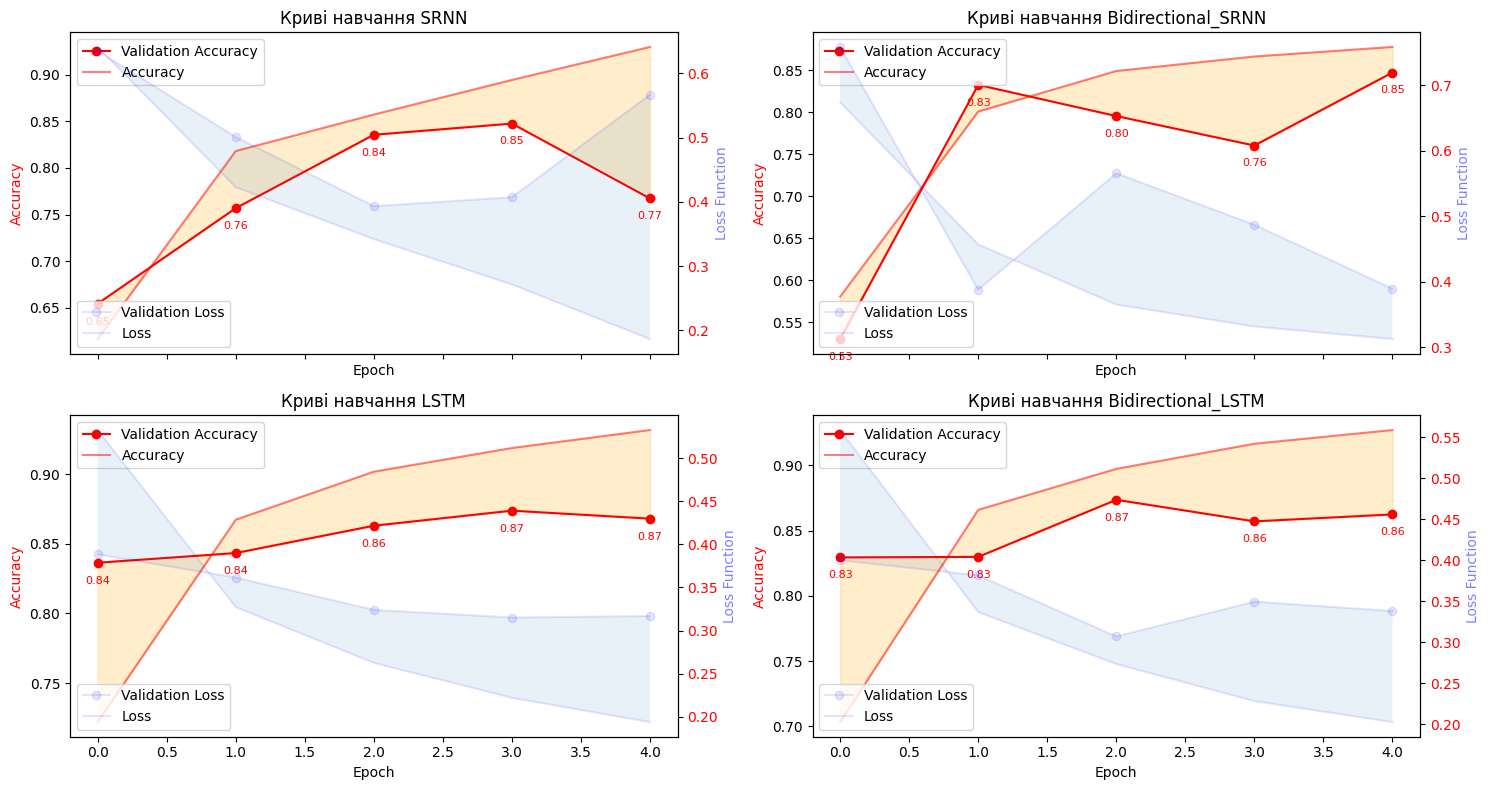

In [11]:
fig, axs = plt.subplots(
    len(models_info) // 2, 2, figsize=(15, 4 * (len(models_info) // 2)), sharex=True
)

for i, (model_name, model_info) in enumerate(models_info.items()):
    history = model_info["history"]

    row = i // 2
    col = i % 2

    ax1 = axs[row, col]

    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    val_accuracy = history.history["val_acc"]
    accuracy = history.history["acc"]

    ax1.plot(val_accuracy, label="Validation Accuracy", marker="o", color="r")
    ax1.plot(accuracy, label="Accuracy", color="r", alpha=0.5)
    ax1.fill_between(
        range(len(accuracy)), accuracy, val_accuracy, color="orange", alpha=0.2
    )
    ax1.tick_params(labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy", color="r")

    for j, acc in enumerate(val_accuracy):
        ax1.annotate(
            f"{acc:.2f}",
            (j, acc),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            c="r",
            fontsize=8,
        )

    ax2 = ax1.twinx()

    ax2.plot(val_loss, label="Validation Loss", marker="o", color="b", alpha=0.1)
    ax2.plot(loss, label="Loss", color="b", alpha=0.1)
    ax2.set_ylabel("Loss Function", color="b", alpha=0.5)
    ax2.fill_between(range(len(loss)), loss, val_loss, alpha=0.1)

    ax2.tick_params(axis="y", labelcolor="r")
    ax2.grid(True, linestyle="--")

    ax2.legend(loc="lower left")

    plt.grid()
    plt.title(f"Криві навчання {model_name}")

plt.tight_layout()
plt.savefig(f"training_curves_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

##Візуалізація результатів

In [12]:
import pandas as pd

df = pd.DataFrame(models_info)

# Deleting the column 'history'
df = df.drop(
    "history",
    axis=0,
).transpose()

df

,edu_time,test_loss,test_acc,eval_time
SRNN,293.75,0.56,0.77,41.08
Bidirectional_SRNN,564.25,0.38,0.85,82.05
LSTM,683.88,0.33,0.86,82.06
Bidirectional_LSTM,1199.49,0.35,0.85,142.05


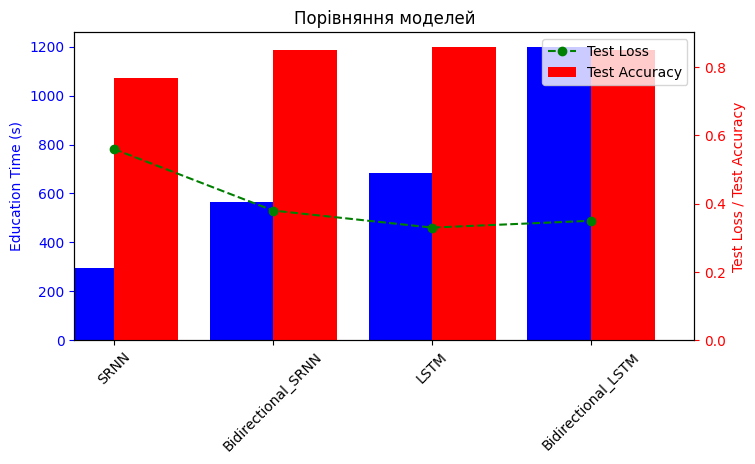

In [14]:
df.to_csv(f"data_epochs_{epochs}_batch_{batch_size}.csv", index=True, sep=" ")
fig, ax1 = plt.subplots(figsize=(8, 4))

df["edu_time"].plot(kind="bar", ax=ax1, position=1, color="b", width=0.4)
ax1.set_ylabel("Education Time (s)", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
df["test_acc"].plot(kind="bar", ax=ax2, position=0, color="r", width=0.4)
df["test_loss"].plot(kind="line", ax=ax2, color="g", linestyle="--", marker="o")

ax2.set_ylabel("Test Loss / Test Accuracy", color="r")
ax2.tick_params("y", colors="r")
ax1.set_xticklabels(df.index, rotation=45)
plt.title("Порівняння моделей")
plt.legend(["Test Loss", "Test Accuracy"], loc="upper right")
plt.savefig(f"model_comparison_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")


all_predictions = []
for model in models:
    y_pred = model.build.predict(x_test)
    y_pred = y_pred > 0.5
    all_predictions.append(y_pred)

782/782 [==============================] - 109s 139ms/step


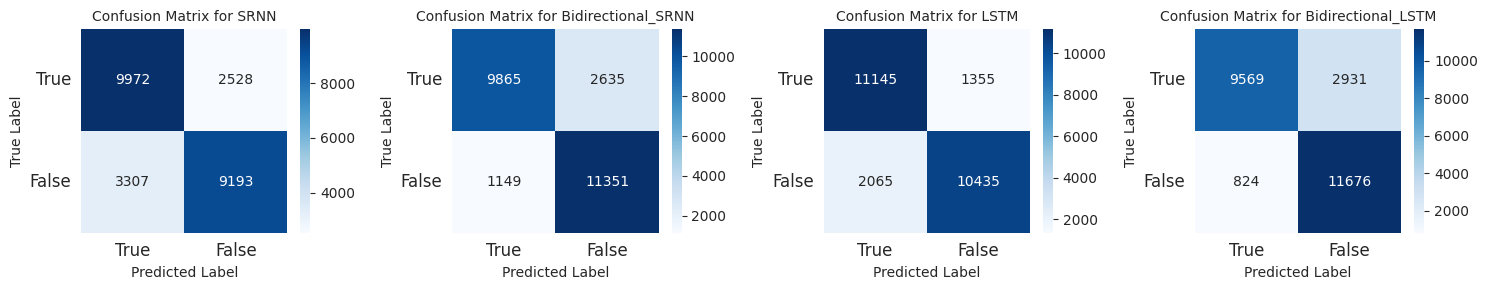

In [16]:
# Створюємо загальну фігуру
fig, axs = plt.subplots(1, len(models), figsize=(15, 3), squeeze=False)

# Визначаємо та відображаємо матриці помилок
for i, model in enumerate(models):
    cm = confusion_matrix(y_test, all_predictions[i])

    df1 = pd.DataFrame(columns=["True", "False"], index=["True", "False"], data=cm)

    sns.heatmap(df1, annot=True, cmap="Blues", fmt=".0f", ax=axs[0, i])
    axs[0, i].set_xlabel("Predicted Label")
    axs[0, i].tick_params(axis="x", labelsize=12)
    axs[0, i].tick_params(axis="y", labelsize=12, rotation=0)
    axs[0, i].set_ylabel("True Label")
    axs[0, i].set_title(f"Confusion Matrix for {model.name}", size=10)

plt.tight_layout()
plt.savefig(f"convolution_matrix_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()